# Online Laplace with a replay buffer

In [1]:
import jax
import optax
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from typing import Callable
from functools import partial
from rebayes.utils import callbacks
from rebayes.utils.utils import tree_to_cpu
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.datasets import rotating_mnist_data as rmnist

In [2]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        return x

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(0, 1.5, n_configs)
    # angles = np.exp(t) * np.sin(35 * t)
    angles = np.sin(35 * t)
    angles = (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
    return angles

In [5]:
num_train = None
frac_train = 1.0
target_digit = 2
data = rmnist.load_and_transform(
    damp_angle, target_digit, num_train, frac_train, sort_by_angle=False
)

ymean, ystd = data["ymean"], data["ystd"]
X_train, Y_train, labels_train = data["dataset"]["train"]

In [6]:
model = MLP()
buffer_size = 10
tx = optax.adam(5e-4)
key = jax.random.PRNGKey(314)
agent = rsgd.init_regression_agent(
    key, model, X_train, tx, buffer_size
)

In [7]:
callback = partial(callbacks.cb_reg_sup, 
                   apply_fn=agent.apply_fn, ymean=ymean, ystd=ystd,
                   X_test=X_train, y_test=Y_train)

bel, output_rsgd = agent.scan(X_train, Y_train, progress_bar=True, callback=callback)
bel = jax.block_until_ready(bel)
output_rsgd = tree_to_cpu(output_rsgd)

  0%|          | 0/5958 [00:00<?, ?it/s]

In [8]:
ksize = 25
kernel = np.ones(ksize) / ksize

In [16]:
_, J = agent.loss_grad(bel.mean, bel.counter, X_train[:10], Y_train[:10], bel.apply_fn)

In [18]:
jax.tree_map(np.shape, J)

FrozenDict({
    params: {
        Dense_0: {
            bias: (100,),
            kernel: (784, 100),
        },
        Dense_1: {
            bias: (100,),
            kernel: (100, 100),
        },
        Dense_2: {
            bias: (100,),
            kernel: (100, 100),
        },
        last-layer: {
            bias: (1,),
            kernel: (100, 1),
        },
    },
})

(1.2517138628661633, 7.626138995504378)

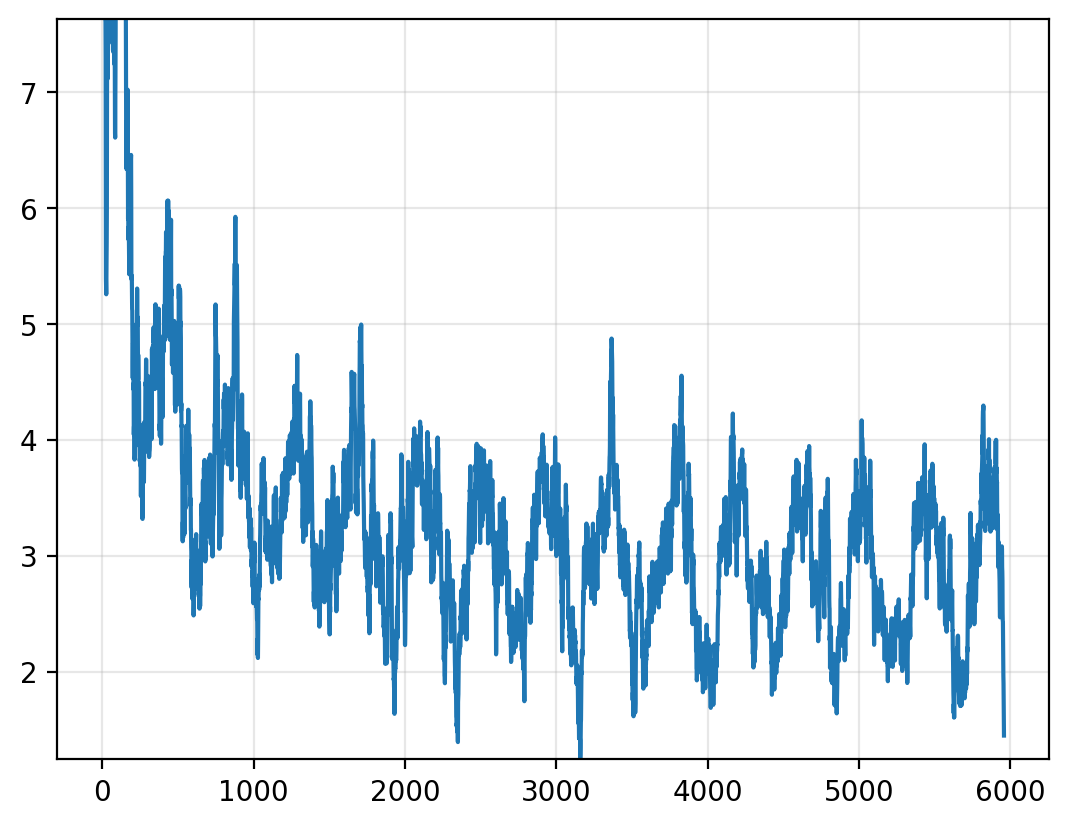

In [86]:
err_smooth = output_rsgd["osa-error"]
err_smooth = np.convolve(err_smooth, kernel, mode="same")
plt.plot(err_smooth)
plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth, 0.00)
vmax = np.quantile(err_smooth, 0.98)
plt.ylim(vmin, vmax)